## Variational quantum algorithms (Quantum neural network)

- A family of quantum algorithms designed for the quantum devices in the near term.
- Quantum analogue of neural networks
- Quantum heuristics, no theoretical guarantee 
- Versatile framework

<img src="./assets/vqa.png" width="500">

(Figure from [Cerezo, M. et al. Variational quantum algorithms. Nat. Rev. Phys. 3, 625–644 (2021)](https://www.nature.com/articles/s42254-021-00348-9))

### 1. Workflow

1. Define the problem and the cost function
2. Choose an appropriate circuit ansatz
3. Get value of the objective function (and gradient, etc) with a quantum computer
4. Update parameters with a classical computer

Below, we will use QAOA (Quantum Approximate Optimization Algorithm) to solve Max Cut as a illustrating example [[Farhi, Goldstone, and Gutmann, arXiv:1411.4028](https://arxiv.org/abs/1411.4028)].

### 2. Max Cut

Given a graph $G = (V, E)$, find a partition of nodes into two groups, such that the bipartition goes through the maximum number of edges. 

We first generate a random 3-regular graph with 6 nodes as our working example.

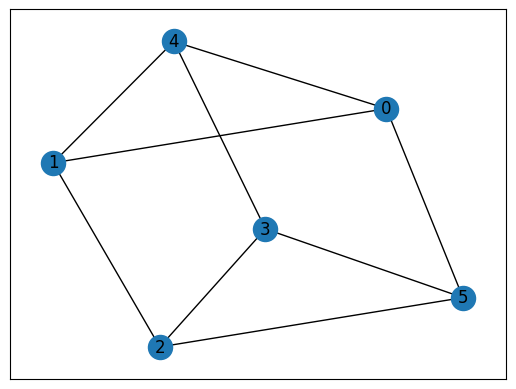

In [4]:
import numpy as np
import networkx as nx

n, d = 6, 3
G = nx.random_regular_graph(d, n, seed = 0)
w = nx.to_numpy_array(G) # adjacency matrix

labels = {i: i for i in range(n)}
pos = nx.spring_layout(G, seed=0) # fix the layout for display purposes
nx.draw_networkx(G, pos, with_labels=True, labels=labels);

Use $x \in \{0,1\}^n$ to denote a bipartition or a "cut", where $x_i = 0$ means the $i$-th node is in the first partition and $x_i = 1$ means that it is in the second one.

The objective function associated with the cut $x$ is defined as 
$$
C(x) = \sum_{(i, j) \in E} x_i \oplus x_j = \frac{1}{2} \sum_{(i, j) \in E} \left( 1 - (-1)^{x_i + x_j} \right)
$$



In [6]:
def cut_value(x: np.ndarray, G: nx.Graph) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        G: Graph.
    Returns:
        Value of the cut.
    """
    obj = 0
    for i, j in G.edges():
        # obj += (x[i] + x[j] - 2*x[i]*x[j])
        obj += 1/2 * (1 - (-1)**(x[i] + x[j]))

    return obj

def binary_repr(n: int, L: int) -> list[int]:
    """
    Wrapper for np.binary_repr that returns a list of ints instead of a string.
    """
    return [int(digit) for digit in np.binary_repr(n, L)]  

**Exercise**: Validate the cut that separates nodes 0, 4 with the others. By inspection, you can see that the cut is 4.

In [7]:
cut_value([1, 0, 0, 0, 1, 0], G) # **

4.0

#### 2.1 Brute-force method
Classically, one can just search over all possible cuts $x$, and output the largest one.

Do note that this is not the best classical algorithm.

This brute force method will tell us what the max cut is, which we will use to verify the performance of QAOA later.

In [8]:
max_cut_value = 0

for i in range(2**n):
    x = binary_repr(i, n)
    if cut_value(x, G) > max_cut_value:
        max_cut_value = cut_value(x, G)
        best_cut = x

print(f'Objective value computed by the brute-force method is {max_cut_value} with the cut {best_cut}')

Objective value computed by the brute-force method is 7.0 with the cut [0, 0, 1, 0, 1, 1]


### 3. Entering quantum

Now we define the quantum operator associated with the objective function.

We apply the mapping $(-1)^{x_i} \to Z_i$.

Then, the observable for the cut value is given by
$$
H_C = \frac{1}{2} \sum_{(i, j) \in E} (I - Z_i Z_j)
$$

You may verify that in this way,
$$
H_C \ket{x} = C(x) \ket{x}
$$

In [9]:
from qiskit.quantum_info import Pauli, SparsePauliOp

**Exercise**: write a function `max_cut_hamiltonian` that takes a graph `G` as input and returns the Hamiltonian.

Hint: use `Pauli` and `SparsePauliOp` to achieve this.

To define $Z_0 Z_3$, you may use `SparsePauliOp(Pauli((z, x)))`, where `z = (1, 0, 0, 1, 0, 0)` and `x = (0, 0, 0, 0, 0, 0)`.

Check the API reference of [`SparsePauliOp`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp) for more information.

In [10]:
def max_cut_hamiltonian(G: nx.Graph) -> SparsePauliOp:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    ham = m/2 * SparsePauliOp("I"*n)
    for i, j in G.edges():
        z = np.zeros(n)
        z[i] = 1 # **
        z[j] = 1 # **
        ham += - 1/2 * SparsePauliOp(Pauli((z, np.zeros(n))))

    return ham

Define the observable (or in a fancy way, the Hamiltonian) associated with the graph `G`

In [11]:
ham = max_cut_hamiltonian(G)

**Exercise**: Validate the function `max_cut_hamiltonian` by checking the maximum eigenvalue of `ham`

Hint: Check the documentation of [`SparsePauliOp`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp). Choose the correct method to get the numpy array for its matrix.

In [12]:
from numpy.linalg import eigvals

ham_matrix = ham.to_matrix() # **
print(f'Maximum eigenvalue of the Hamiltonian is {max(eigvals(ham_matrix))}')

Maximum eigenvalue of the Hamiltonian is (7+0j)


### 4. Define the circuit

The circuit structure of QAOA is inspired from the quantum adiabatic algorithm.

A $p$-level QAOA circuit is defined by
$$
C(\gamma, \beta) = e^{-i \beta_p H_B} e^{-i \gamma_p H_C} \cdots e^{-i \beta_1 H_B} e^{-i \gamma_1 H_C} H^{\otimes n} = \left( \prod_{\ell = 1}^p e^{-i \beta_{\ell} H_B} e^{-i \gamma_{\ell} H_C} \right) H^{\otimes n}  \tag{1}
$$
where $\gamma, \beta \in [-\pi, \pi]^p$ and
$$
\begin{aligned}
H_B = \sum_{j=1}^n X_j
\end{aligned}
$$

#### 4.1 Circuit decomposition

To implement $C(\gamma, \beta)$ on a quantum computer, we will need to decompose it into smaller gates, usually single-qubit and two-qubit gates.

The decomposition of $e^{-i \beta_{\ell} H_B}$ is easy $\text{(\textcolor{red}{why?})}$:
$$
e^{-i \beta_{\ell} H_B} = \prod_{j \in V} e^{-i \beta_{\ell} X_j}  \tag{2}
$$
which is a bunch of $X$ rotations.

The decomposition of $e^{-i \gamma_{\ell} H_C}$ follows similarly,
$$
e^{-i \gamma_{\ell} H_C} \propto \prod_{(j, k) \in E} e^{-i \gamma_{\ell} Z_j Z_k}  \tag{3}
$$
It can be further decomposed with the following circuit identity into CNOTs and $Z$ rotations

<img src="./assets/ZZ_rotation.png" width="500">

**Exercise**: complete the following function that defines the QAOA circuit. Refer to Eqs. (1-3)

In [13]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def qaoa(G: nx.Graph, p) -> QuantumCircuit:
    """
    Args:
        G: Graph.
        p: Number of layers.
    Returns:
        Quantum circuit implementing the QAOA.
    """
    n = G.number_of_nodes()
    gamma = ParameterVector('$\\gamma$', p)
    beta = ParameterVector('$\\beta$', p)
    qc = QuantumCircuit(n)
    # first Hadamard layer
    qc.h(range(n)) 
    
    for i in range(p):
        # H_C block
        for j, k in G.edges():
            qc.cx(j, k) # **
            qc.rz(2*gamma[i], k) # **
            qc.cx(j, k) # **
        # H_B block
        qc.rx(2*beta[i], range(n)) # **

    qc.measure_all()

    return qc

d:\Software\Miniconda3\envs\qiskit\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


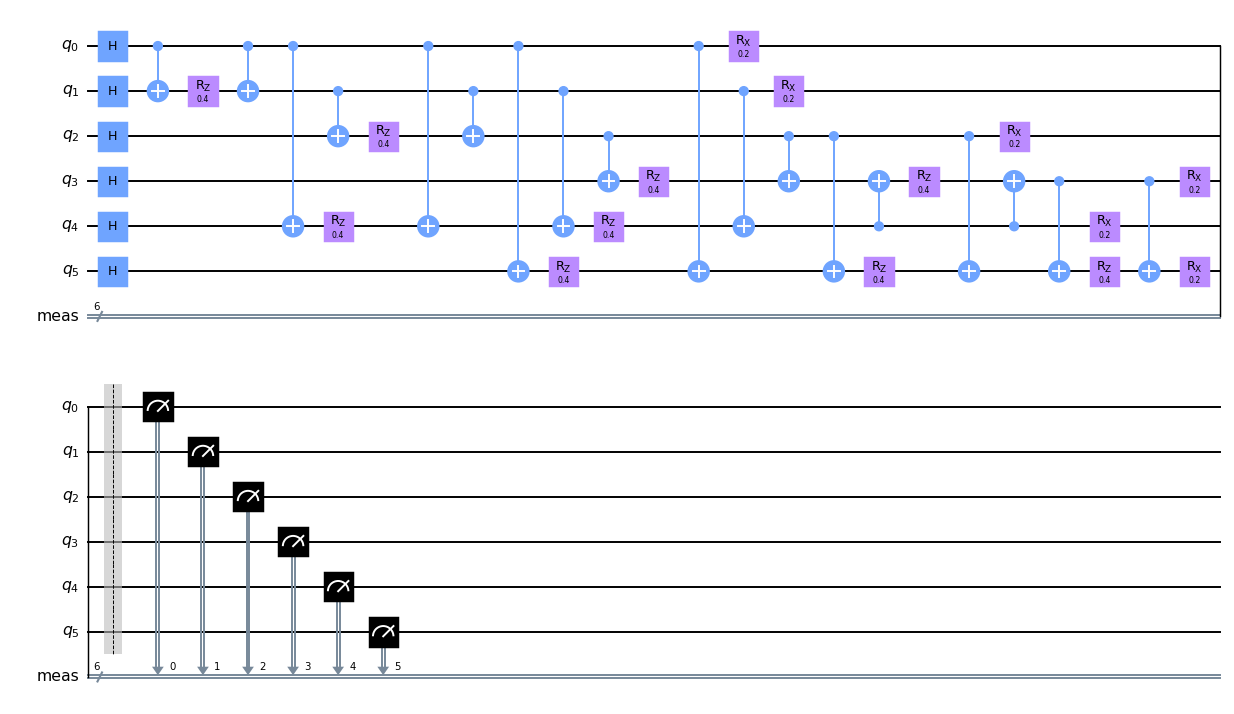

In [14]:
qc = qaoa(G, 1).assign_parameters([0.1, 0.2])
qc.draw("mpl", scale=0.7)

### 5. Training 

#### 5.1 Mimic the quantum process of getting objective values

Now, we are going to get the expectation value of the Hamiltonian $H_C$, denoted as $\langle H_C \rangle$. 

This will be a function of the parameters $\gamma$ and $\beta$. 

We then vary the parameters to maximize $\langle H_C \rangle$.

The actual process of getting this value on a quantum computer is as follows. First, we run the QAOA circuit, measure it, and get a sample $x \in \{0, 1\}^n$. The sample $x$ defines a bipartition or a cut, as we saw before, and we get the eigenvalue $C(x)$.

We will repeat this process $T$ times, to get a list of samples $x_1, x_2, \cdots, x_T$. The estimate of $\langle H_C \rangle$ will be
$$
\frac{1}{T} \sum_{j = 1}^T C(x_j)
$$

So, we want to write a function, that takes a quantum circuit (or equivalently, the parameters $\gamma$ and $\beta$) as input, and outputs an estimate of $\langle H_C \rangle$, based on the above process.

**Exercise**: complete the following function.

Hint: check the API reference of [`qiskit.result.Result`](https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result#get_counts). `counts` is a dictionary, so what are its keys and values?

In [15]:
from qiskit import Aer

simulator = Aer.get_backend("aer_simulator")

def obj_func(params, shots = 1000):
    p = len(params)//2
    qc = qaoa(G, p).assign_parameters(params) # assign parameters to the circuit
    result = simulator.run(qc, shots = shots).result() # run the circuit and get the result
    counts = result.get_counts(qc) # process the result
    res = 0
    for x in counts:
        res += counts[x] * cut_value([int(digit) for digit in x], G) # **

    return -res/sum(counts.values()) # minus sign because we want to use a minimizer later

#### 5.2 Parameter update

This can be achieved by gradient descent or other optimizers you like. For simplicity, we will just use the `minimize` function from `scipy`.

In [16]:
from scipy.optimize import minimize
from numpy.random import default_rng

In [35]:
p = 2 # a 2-level QAOA
shots = 10000
params_0 = default_rng(0).uniform(-np.pi, np.pi, 2*p) # initial parameters
res = minimize(obj_func, params_0, args = (shots), method='L-BFGS-B', options={'maxiter': 1000})
print(f'Average objective value computed by the COBYLA method is {-res.fun}')

Average objective value computed by the COBYLA method is 4.2474


The average is not bad, quite close to the maximum value, which is 7.

Now let's check the most frequent occurring bit string of the final state, to see whether it gives the true max cut

In [36]:
params_final = res.x
qc = qaoa(G, p).assign_parameters(params_final)
result = simulator.run(qc, shots = shots).result()
counts = result.get_counts(qc)
max_cut_qaoa = [int(digit) for digit in counts.most_frequent()] # most frequent bitstring
print(f'Objective value computed by the QAOA method is {cut_value(max_cut_qaoa, G)} with the cut {max_cut_qaoa}')

Objective value computed by the QAOA method is 7.0 with the cut [1, 1, 0, 1, 0, 0]


Done!

#### Extension: 

The above is a general framework for working on variational quantum algorithms with qiskit.

For QAOA, qiskit actually has an integrated function.

Below is how you can use it.

We first define a helper function that returns the bit string with highest occurring probability when measuring a state vector.

In [11]:
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution

def sample_most_likely(state_vector: Statevector | QuasiDistribution) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = binary_repr(k, n)
    # x.reverse()
    return np.asarray(x)

In [12]:
print(Statevector.from_label('110'))
print(sample_most_likely(Statevector.from_label('110')))

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
[1 1 0]


Below is to use the functions already written by qiskit

In [60]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals

sampler = Sampler()

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2) # p = 2

result = qaoa.compute_minimum_eigenvalue(-ham)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {cut_value(x, G)}')

C:\Users\buyet\AppData\Local\Temp\ipykernel_8848\4241725682.py:8: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 10598


[0 0 1 0 1 1]
Objective value computed by QAOA is 7.0


In [36]:
import qiskit.tools.jupyter
%qiskit_version_table